# Create model arquitecture

In [48]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
    return ds

In [3]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float64)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [4]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))

    feature_columns.append(set_one_hot_feature('abtest', data))
    
    feature_columns.append(set_embedding_feature('vehicleType', data, 4))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    feature_columns.append(set_embedding_feature('model', data, 8))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    feature_columns.append(set_embedding_feature('brand', data, 6))
    
    feature_columns.append(set_one_hot_feature('notRepairedDamage', data))
    
    feature_columns.append(set_embedding_feature('postalCode', data, 10))
    

    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [19]:
train = preprocessing_fn(path='data/train.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv')
val = preprocessing_fn(path='data/val.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv')

In [20]:
train.dtypes

dateCrawled             object
name                    object
seller                  object
offerType               object
price                    int64
abtest                  object
vehicleType             object
yearOfRegistration     float32
gearbox                 object
powerPS                float32
model                   object
kilometer              float32
monthOfRegistration      int64
fuelType                object
brand                   object
notRepairedDamage       object
dateCreated             object
nrOfPictures             int64
postalCode               int64
lastSeen                object
dtype: object

In [24]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=200)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=200)

In [25]:
feature_layer = feature_columns(train, train_ds)

In [ ]:

# x = layers.Dense(100, activation='relu')(feature_layer)

# x = layers.Dense(100, activation='relu')(x)

# output = layers.Dense(1, activation='relu')(x)

# model = keras.Model(inputs=feature_layer, outputs=output, name="my_model")

In [55]:
dp_rate = 0.2
lr = 0.001
hu = 150

model = keras.Sequential([
    feature_layer,
    layers.BatchNormalization(),
    layers.Dense(60, activation='relu'),
    layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    #layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    #layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(240, activation='relu'),
    layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(240, activation='relu'),
    #layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    #layers.Dropout(rate=dp_rate),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(rate=dp_rate),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_absolute_error','mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
970/970 [==============================] - 18s 19ms/step - loss: 2501.8176 - mean_absolute_error: 2501.8176 - mean_squared_error: 18478010.0000 - val_loss: 1441.0879 - val_mean_absolute_error: 1441.0879 - val_mean_squared_error: 6007717.5000
Epoch 2/15
970/970 [==============================] - 18s 18ms/step - loss: 1329.0837 - mean_absolute_error: 1329.0837 - mean_squared_error: 4742922.5000 - val_loss: 1686.4180 - val_mean_absolute_error: 1686.4180 - val_mean_squared_error: 582704768.0000
Epoch 3/15
970/970 [==============================] - 18s 18ms/step - loss: 1237.8044 - mean_absolute_error: 1237.8044 - mean_squared_error: 4063925.0000 - val_loss: 1820.6105 - val_mean_absolute_error: 1820.6105 - val_mean_squared_error: 845606784.0000
Epoch 4/15
970/970 [==============================] - 22s 22ms/step - loss: 1204.1576 - mean_absolute_error: 1204.1576 - mean_squared_error: 3829397.2500 - val_loss: 2268.1924 - val_mean_absolute_error: 2268.1924 - val_mean_squared_error: 

In [57]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,2501.817627,2501.817627,18478010.00,1441.087891,1441.087891,6.007718e+06,0
1,1329.083740,1329.083740,4742922.50,1686.417969,1686.417969,5.827048e+08,1
2,1237.804443,1237.804443,4063925.00,1820.610474,1820.610474,8.456068e+08,2
3,1204.157593,1204.157593,3829397.25,2268.192383,2268.192383,3.975843e+09,3
4,1177.657471,1177.657471,3650519.50,2233.193604,2233.193604,3.238203e+09,4
5,1160.820679,1160.820679,3530228.75,2008.986084,2008.986084,1.292224e+09,5
6,1146.509399,1146.509399,3455232.50,1975.152222,1975.152222,1.531208e+09,6
7,1137.746826,1137.746826,3396470.25,2287.522461,2287.522461,3.781892e+09,7
8,1134.409546,1134.409546,3383429.75,1886.685303,1886.685303,1.252201e+09,8
9,1116.850586,1116.850708,3284312.25,1946.682617,1946.682617,9.236753e+08,9


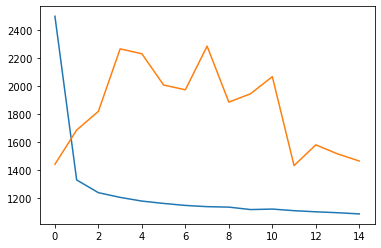

In [73]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)

In [33]:
train_pred = model.predict(train_ds).flatten()

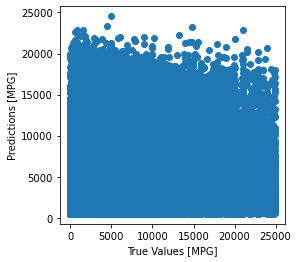

In [37]:
# a = plt.axes(aspect='equal')
plt.scatter(train.price, preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

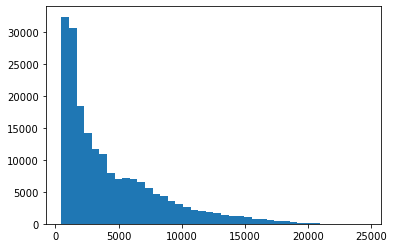

In [41]:
plt.hist(preds, bins=40)
plt.show()

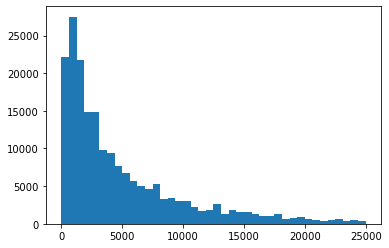

In [42]:
plt.hist(train.price, bins=40)
plt.show()

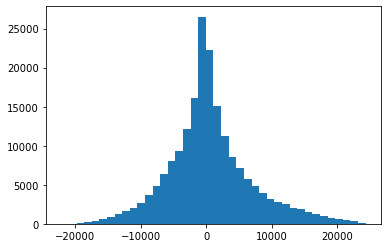

In [40]:
plt.hist(train.price - preds, bins=40)
plt.show()

In [14]:
train.price.describe()

count    1.998190e+05
mean     7.090404e+03
std      1.089688e+05
min      1.000000e+00
25%      1.250000e+03
50%      3.000000e+03
75%      7.490000e+03
max      1.400050e+07
Name: price, dtype: float64

In [15]:
val.price.describe()

count    5.049900e+04
mean     8.969192e+03
std      3.661537e+05
min      1.000000e+00
25%      1.250000e+03
50%      3.000000e+03
75%      7.500000e+03
max      7.418530e+07
Name: price, dtype: float64